# Generative Adversarial Network for MNIST

In [1]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets, transforms

In [2]:
import numpy as np

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

### Description

Generative adversarial network to sample the MNIST dataset of hand-written digits.

### GPU

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Dataset

In [5]:
batch_size = 64

transform = transforms.ToTensor()

trainset = datasets.MNIST(root="", train=True, download=True, transform=transform)
testset = datasets.MNIST(root="", train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

trainiter = iter(trainloader)
testiter = iter(testloader)

print(len(trainset), len(testset))

60000 10000


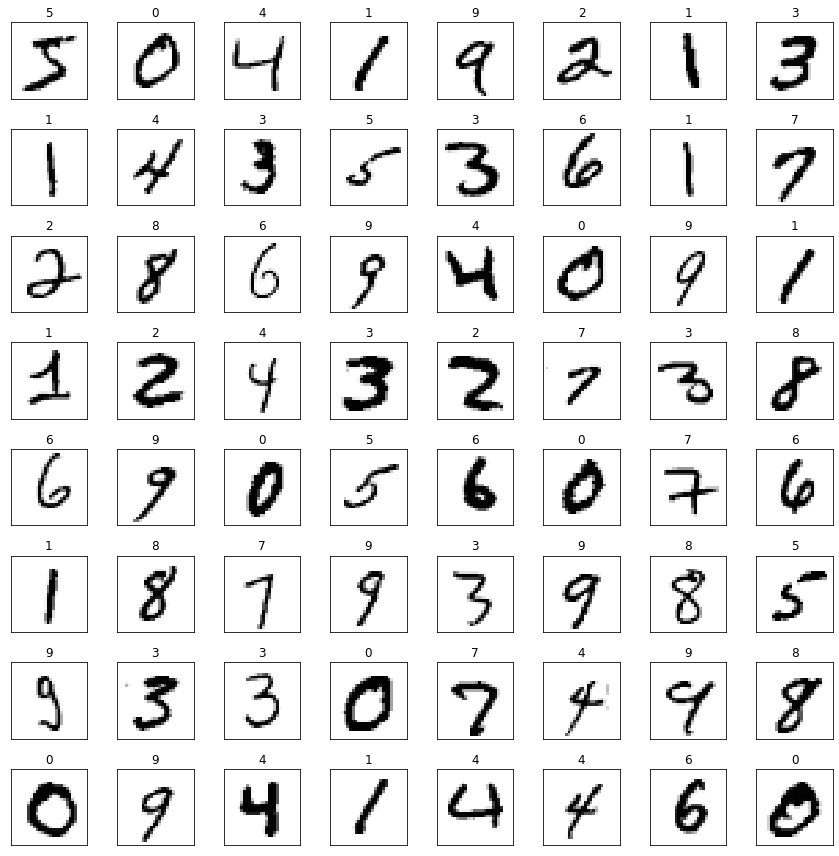

In [6]:
images, labels = next(trainiter)

fig = plt.figure(figsize=(12,12))
for idx in range(64):
    ax = fig.add_subplot(8, 8, idx + 1, xticks=[], yticks=[])
    
    # Un-normalize image
    img = images[idx].numpy().squeeze()

    # Transpose image from C x H x W to H x W x C
    plt.imshow(img, cmap='Greys')
    
    # Get name
    name = str(labels[idx].item())
    
    ax.set_title(name, fontdict={"fontsize": 12})

plt.tight_layout()
plt.show()

## Model

### Discriminator

In [7]:
class Discriminator(nn.Module):

    def __init__(self, leak=0.2):
        super().__init__()

        self.leak = leak
        
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        
        self.dropout = nn.Dropout(0.25)
        
        
    def forward(self, x):
        # Flatten image
        x = x.view(-1, 28 * 28)

        x = F.leaky_relu(self.fc1(x), self.leak)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), self.leak)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), self.leak)
        x = self.dropout(x)
        x = self.fc4(x) # Raw output

        return x


### Generator

In [8]:
class Generator(nn.Module):

    def __init__(self, z_size, leak=0.2):
        super().__init__()

        self.leak = leak
        
        self.fc1 = nn.Linear(z_size, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, 28 * 28)
        
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), self.leak)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), self.leak)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), self.leak)
        x = self.dropout(x)
        x = F.tanh(self.fc4(x)) # tanh activation

        return x

## Training

In [9]:
# Generator latent vector size
z_size = 128

D = Discriminator()
G = Generator(z_size)

### Discriminator Loss

In [10]:
def real_loss(D_out, smooth=True):
    batch_size = D_out.size(0)

    # For real images D_out (discriminator output) should be one
    if smooth:
        # Smooth labels
        labels = torch.ones(batch_size) * 0.9
    else:
        labels = torch.ones(batch_size)
        
    # BCELoss with raw output
    return F.binary_cross_entropy_with_logits(D_out.squeeze(), labels)

def fake_loss(D_out):
    batch_size = D_out.size(0)

    # For fake images, D_out (discriminator output) should be zero
    labels = torch.zeros(batch_size)

    # BCELoss with raw output
    return F.binary_cross_entropy_with_logits(D_out.squeeze(), labels)

### Optimiser

In [11]:
# Optimizers
lr = 1e-3

# Create optimizers for discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

In [12]:
from tqdm import trange, tqdm

n_epochs = 100

# keep track of loss and generated, "fake" samples
samples = []
losses = []

# Fixed data for sampling new images
sample_size = 16
uniform = torch.distributions.uniform.Uniform(-1, 1) # Uniform distribution
fixed_z = uniform.sample(sample_shape=(sample_size, z_size))

# Models in train model (for dropout layers)
D.train()
G.train()

for epoch in trange(n_epochs + 1):
    
    for i, (real_images, _) in enumerate(trainloader):
                
        batch_size = real_images.size(0)
        
        # Rescale input images from [0,1) to [-1, 1)
        # This is consistent with the tanh activation function
        # of the generator
        real_images = real_images * 2 - 1

        # DISCRIMINATOR TRAINING
        d_optimizer.zero_grad()

        # Discriminator predictions and losses for real images
        D_real = D(real_images) 
        d_real_loss = real_loss(D_real)
        
        # Generate fake images
        z = uniform.sample(sample_shape=(batch_size, z_size))
        fake_images = G(z)
        
        # Discriminator predictions and losses for fake images       
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # Total loss
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()

        # Update weights
        d_optimizer.step()
        
        
        # GENERATOR TRAINING
        g_optimizer.zero_grad()
        
        # Generate fake images
        z = uniform.sample(sample_shape=(batch_size, z_size))
        fake_images = G(z)
        
        # Discriminator predictions and losses for fake images
        # This now uses real_loss instead of fake_loss
        # in order to flip the labels
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake)
        
        # Update weights
        g_loss.backward()
        g_optimizer.step()

    tqdm.write(f" d_loss = {d_loss.item():.5f} | g_loss = {g_loss.item():.5f}")

    # Store losses
    losses.append((d_loss.item(), g_loss.item()))

    # Generate fake images from fixed sample
    G.eval()
    samples.append(G(fixed_z))
    G.train()


100%|██████████| 101/101 [1:24:43<00:00, 50.34s/it] d_loss = 1.21691 | g_loss = 1.00482



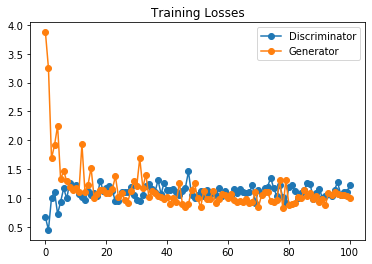

In [13]:
plt.figure()
losses = np.array(losses)
plt.plot(losses[:,0], "o-", label='Discriminator')
plt.plot(losses[:,1], "o-", label='Generator')
plt.title("Training Losses")
plt.legend()

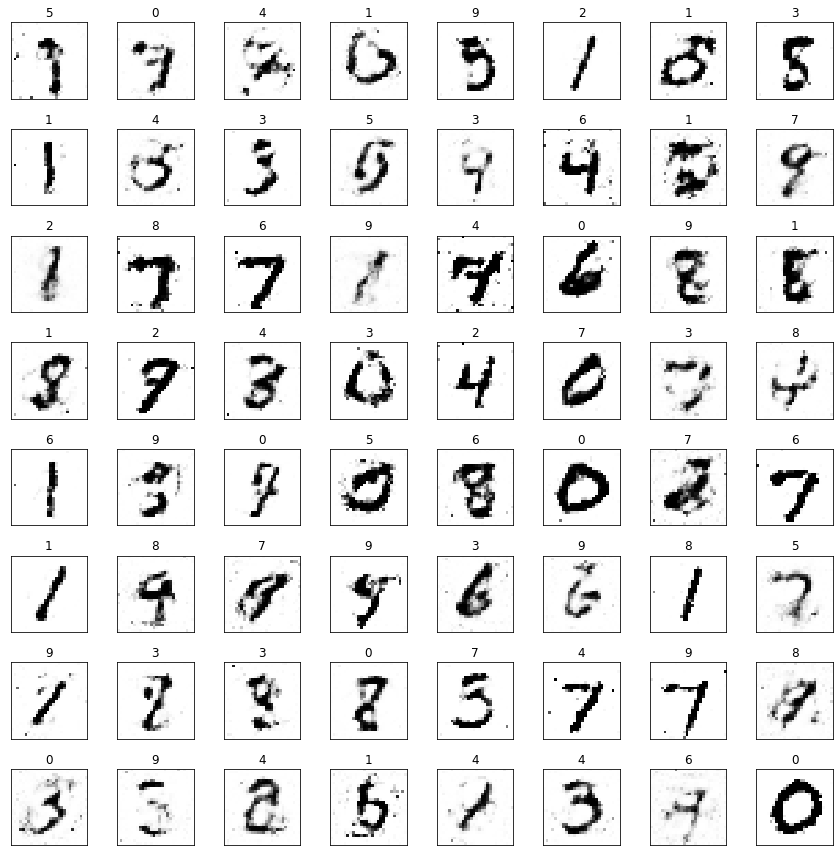

In [14]:
images = G(uniform.sample(sample_shape=(64, z_size)))

fig = plt.figure(figsize=(12,12))
for idx in range(64):
    ax = fig.add_subplot(8, 8, idx + 1, xticks=[], yticks=[])

    # Un-normalize image
    img = images[idx].detach().view(28,28).numpy().squeeze()

    # Transpose image from C x H x W to H x W x C
    ax.imshow(img, cmap='Greys')
    
    # Get name
    name = str(labels[idx].item())
    
    ax.set_title(name, fontdict={"fontsize": 12})

plt.tight_layout()
plt.show()

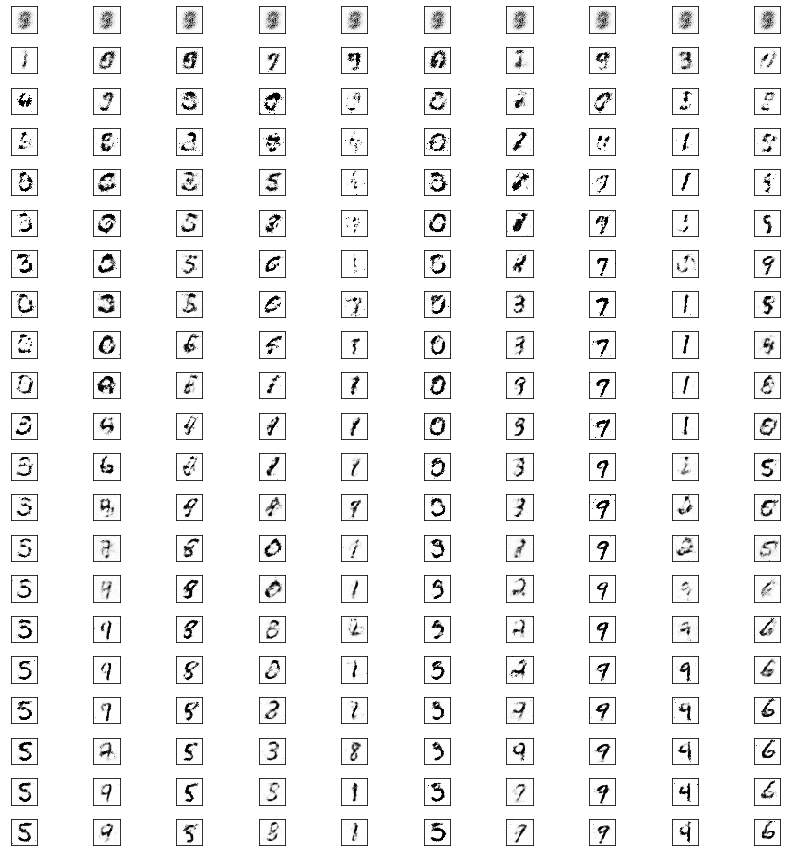

In [15]:
subsamples = samples[::5]
n = len(subsamples)

fig = plt.figure(figsize=(12,12))
for row in range(n):
    for col in range(10):
        ax = fig.add_subplot(n, 10, col + 10 * row + 1, xticks=[], yticks=[])

        # Un-normalize image
        img = subsamples[row][col].detach().view(28,28).numpy().squeeze()

        # Transpose image from C x H x W to H x W x C
        ax.imshow(img, cmap='Greys')

        # Remove axes
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

plt.tight_layout()
plt.show()